In [0]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image

from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [0]:
print(torch.__version__)

1.4.0


In [0]:
class AdamE(optim.Optimizer):
    r"""Implements AdamE with enforced decay algorithm.
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 M=10, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0 <= M:
            raise ValueError("Invalid M value: {}".format(M))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, M=M,
                        weight_decay=weight_decay)
        super(AdamE, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamE, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
             closure (callable, optional): A closure that reevaluates the model
                 and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # moving average of gradient values(Exponential moving average of gradient values)
                    state['avg'] = torch.zeros_like(p.data) 
                    # moving average of squared gradient values(Exponential moving average of squared gradient values)
                    state['avg_sq'] = torch.zeros_like(p.data)
                    # t - M + 1 step gradient
                    state['t_M_1'] = torch.zeros_like(p.data)

                avg, avg_sq = state['avg'], state['avg_sq']
                t_M_1 = state['t_M_1']
                beta1, beta2 = group['betas']
                M = group['M']
                
                factor = 1./M

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                if state['step'] == 1: # do it manually at the first iteration
                    avg.add_(grad, alpha=factor) # avg_at_t = avg_at_t-1 + (1/M) * grad
                    avg_sq.addcmul_(grad, grad, value=factor)
                    t_M_1.add_(grad)
                elif not state['step'] % (M + 1):
                    # do averaging at M + 1 iteration
                    grad.add_(-t_M_1, alpha=factor) # change gradients to (1/M) * (x[n] - x[n-M+1])
                    avg.add_(grad, alpha=factor) # avg_at_t = avg_at_t-1 + (1/M) * grad
                    avg_sq.addcmul_(grad, grad, value=factor)
                    
                    t_M_1 = torch.zeros_like(grad)
                    t_M_1.add_(grad)
                else:
                    avg.add_(grad, alpha=factor) # avg_at_t = avg_at_t-1 + (1/M) * grad
                    avg_sq.addcmul_(grad, grad, value=factor) # do the same but grad^2

                denom = (avg_sq.sqrt() * M).add_(group['eps'])
                step_size = group['lr'] * M
                p.data.addcdiv_(-step_size, avg, denom)
                
                if not state['step'] % (M + 1):
                    # To think - do we need to reset
                    # averages buffers after averaging?
                    avg = torch.zeros_like(grad)
                    avg_sq = torch.zeros_like(grad)

        return loss

In [0]:
# training batches of our network
EPOCHS = 15
# size of each batch
BATCH_SIZE = 512

DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)

print(DEVICE)

1.4.0
cuda


In [0]:
from google.colab import drive

# mount your Google Drive
drive.mount("/content/gdrive") 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_csv = pd.read_csv('/content/gdrive/My Drive/fashion-mnist_train.csv')
test_csv = pd.read_csv('/content/gdrive/My Drive/fashion-mnist_test.csv')

In [0]:
print(train_csv.shape)
print(test_csv.shape)

(60000, 785)
(10000, 785)


In [0]:
print(train_csv.info())
print(train_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      2       0       0       0  ...         0         0         0         0
1      9       0       0       0  ...         0         0         0         0
2      6       0       0       0  ...         0         0         0         0
3      0       0       0       0  ...         0         0         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [0]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label


In [0]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [0]:
train_loader = DataLoader(
    FashionDataset(train_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(
    FashionDataset(test_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(EPOCHS + 1)]

Shirt


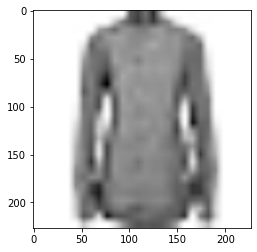

In [0]:

# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [0]:
class fasion_mnist_alexnet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [0]:
model = fasion_mnist_alexnet().to(DEVICE)
torch.save(model.state_dict(), '/content/gdrive/My Drive/initial_weights.pth')
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr = 5e-6)

In [0]:
def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    checkpoint = {'model': fasion_mnist_alexnet(),
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, '/content/gdrive/My Drive/ADAM_fashion_mnist.pth')


In [0]:
# acc = []
# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += criterion(output, target, reduction='sum').item()
#             pred = output.max(1, keepdim=True)[1]
#             correct += pred.eq(target.view_as(pred)).sum().item()
#     test_loss /= len(test_loader.dataset)  
#     test_losses.append(test_loss)
#     calc=100. * correct / len(test_loader.dataset)
#     acc.append(calc)
#     print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
#             test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
#     print('='*50)


# print(acc)

In [0]:
acc = []
ls = []
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)  
    test_losses.append(test_loss)
    calc=100. * correct / len(test_loader.dataset)
    acc.append(calc)
    ls.append(test_loss)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    print('='*50)


print(acc)

[]


In [0]:
%%time
for epoch in range(1, EPOCHS+1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)


Train Epoch:1 [14848/60000 (25%)]	Loss: 2.266076
Train Epoch:1 [30208/60000 (50%)]	Loss: 1.898034
Train Epoch:1 [45568/60000 (75%)]	Loss: 1.155612


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type fasion_mnist_alexnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Test set: Average loss: 0.9992, Accuracy: 6203/10000 (62%)

Train Epoch:2 [14848/60000 (25%)]	Loss: 0.991461
Train Epoch:2 [30208/60000 (50%)]	Loss: 0.850332
Train Epoch:2 [45568/60000 (75%)]	Loss: 0.813436

Test set: Average loss: 0.7844, Accuracy: 7038/10000 (70%)

Train Epoch:3 [14848/60000 (25%)]	Loss: 0.739820
Train Epoch:3 [30208/60000 (50%)]	Loss: 0.654756
Train Epoch:3 [45568/60000 (75%)]	Loss: 0.630525

Test set: Average loss: 0.6760, Accuracy: 7522/10000 (75%)

Train Epoch:4 [14848/60000 (25%)]	Loss: 0.622216
Train Epoch:4 [30208/60000 (50%)]	Loss: 0.696402
Train Epoch:4 [45568/60000 (75%)]	Loss: 0.611027

Test set: Average loss: 0.6139, Accuracy: 7666/10000 (77%)

Train Epoch:5 [14848/60000 (25%)]	Loss: 0.628557
Train Epoch:5 [30208/60000 (50%)]	Loss: 0.618680
Train Epoch:5 [45568/60000 (75%)]	Loss: 0.531177

Test set: Average loss: 0.5736, Accuracy: 7835/10000 (78%)

Train Epoch:6 [14848/60000 (25%)]	Loss: 0.532737
Train Epoch:6 [30208/60000 (50%)]	Loss: 0.501003
Train Epo

# **Tests with the new Adam**

In [0]:
#optimizer2 = AdamE(model.parameters(),M = 20,lr = 5e-5)
#optimizer2 = AdamE(model.parameters(),M = 20,lr = e-6)

model.load_state_dict(torch.load('/content/gdrive/My Drive/initial_weights.pth'))
model.eval()
optimizer2 = AdamE(model.parameters(),M = 20,lr = 5e-6)

In [0]:
def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer2.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer2.step()
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    checkpoint = {'model': fasion_mnist_alexnet(),
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer2.state_dict()}
    torch.save(checkpoint, '/content/gdrive/My Drive/ADAME_fashion_mnist.pth')

In [0]:
accur=[]
lss =[]
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  
    calcu = 100. * correct / len(test_loader.dataset)
    accur.append(calcu)
    lss.append(test_loss)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    print('='*50)

In [0]:
%%time
for epoch in range(1, EPOCHS+1):
    train(model, DEVICE, train_loader, optimizer2, epoch)
    test(model, DEVICE, test_loader)

Train Epoch:1 [14848/60000 (25%)]	Loss: 2.284783
Train Epoch:1 [30208/60000 (50%)]	Loss: 2.154226
Train Epoch:1 [45568/60000 (75%)]	Loss: 1.572451


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type fasion_mnist_alexnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Test set: Average loss: 1.2114, Accuracy: 5123/10000 (51%)

Train Epoch:2 [14848/60000 (25%)]	Loss: 1.191042
Train Epoch:2 [30208/60000 (50%)]	Loss: 1.004699
Train Epoch:2 [45568/60000 (75%)]	Loss: 1.049938

Test set: Average loss: 0.9723, Accuracy: 6421/10000 (64%)

Train Epoch:3 [14848/60000 (25%)]	Loss: 0.830511
Train Epoch:3 [30208/60000 (50%)]	Loss: 0.905717
Train Epoch:3 [45568/60000 (75%)]	Loss: 0.839822

Test set: Average loss: 0.7687, Accuracy: 7190/10000 (72%)

Train Epoch:4 [14848/60000 (25%)]	Loss: 0.716982
Train Epoch:4 [30208/60000 (50%)]	Loss: 0.764979
Train Epoch:4 [45568/60000 (75%)]	Loss: 0.672274

Test set: Average loss: 0.6623, Accuracy: 7477/10000 (75%)

Train Epoch:5 [14848/60000 (25%)]	Loss: 0.593750
Train Epoch:5 [30208/60000 (50%)]	Loss: 0.645094
Train Epoch:5 [45568/60000 (75%)]	Loss: 0.649194

Test set: Average loss: 0.6102, Accuracy: 7661/10000 (77%)

Train Epoch:6 [14848/60000 (25%)]	Loss: 0.641346
Train Epoch:6 [30208/60000 (50%)]	Loss: 0.536033
Train Epo

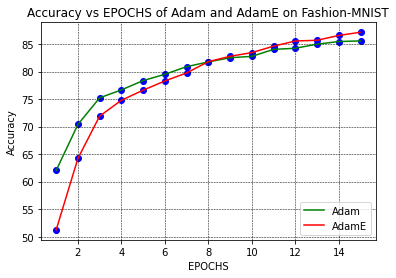

In [0]:
ff = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
fig = plt.figure()


plt.plot(ff,acc,color = 'green')
plt.scatter(ff,acc,color = 'blue')
plt.plot(ff,accur,color = 'red')
plt.scatter(ff,accur,color = 'blue')


plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
plt.title("Accuracy vs EPOCHS of Adam and AdamE on Fashion-MNIST")
plt.legend(["Adam","AdamE"],loc="lower right")


plt.grid(color='black', linestyle='--', linewidth=0.5)

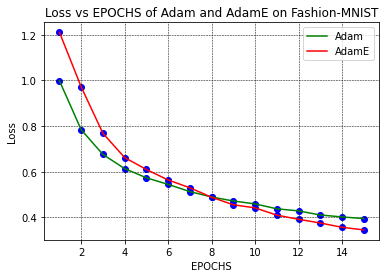

In [0]:
ff = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
fig = plt.figure()
plt.plot(ff,ls,color = 'green')
plt.scatter(ff,ls,color = 'blue')
plt.plot(ff,lss,color = 'red')
plt.scatter(ff,lss,color = 'blue')


plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title("Loss vs EPOCHS of Adam and AdamE on Fashion-MNIST")
plt.legend(["Adam","AdamE"],loc="upper right")


plt.grid(color='black', linestyle='--', linewidth=0.5)